In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    print(self.model.trainable_variables)

my_callback = myCallback()

def reshape_with_overlap(arr, package_shape):
    # Determine the number of packages based on overlap
    num_packages = arr.shape[0] - package_shape[0] + 1
    
    # Create the overlapped reshaped data
    reshaped_list = [arr[i:i+package_shape[0]] for i in range(num_packages)]
    reshaped_arr = np.stack(reshaped_list)
    
    # Return the reshaped array
    return reshaped_arr

In [2]:
def get_z_score(X_train, y_train, X_test):
    '''
    This method will change the feature into z_score

    Parameters
    ----------
    X_train: DataFrame
    - X dataset for training

    y_train: DataFrame
    - y dataset for training
    
    X_test: DataFrame
    - X dataset for testing

    Returns
    -------
    X_train: DataFrame
    - X dataset after transformation for training

    y_train: DataFrame
    - y dataset after transformation for training

    y_origin: DataFrame
    - the original y dataset for training
    
    X_test: DataFrame
    - X dataset after transformation for testing
    '''
    X_mean = None
    X_std = None 
    y_mean = y_train.mean()
    y_std = y_train.std()
    y_origin = y_train.copy()


    X_mean = X_train.apply(np.mean, axis=0)
    X_std = X_train.apply(np.mean, axis=0)

    for i in X_train.columns:
        
        X_train.loc[:, i] = (X_train[i]-X_mean[i])/X_std[i]
        X_test.loc[:, i] = (X_test[i]-X_mean[i])/X_std[i]

    y_train = (y_train-y_mean)/y_std


    return X_train, y_train, y_origin, X_test


def inverse_z_score(y_train, y_pred):
    '''
    This method is used to inverse the process of transforming target to z_score

    Parameters
    ----------
    y_train: DataFrame
    - y dataset for training

    y_pred: numpy ndarray
    - predicted y value from model 

    Returns
    -------
    y_train: DataFrame
    - y dataset after transformation for training

    y_pred: numpy ndarray
    - predicted y value from model after inverse of z_score
    '''

    y_mean = y_train.mean()
    y_std = y_train.std()

    y_pred = y_pred*y_std+y_mean
    
    return y_pred


def get_min_max(X_train, y_train, X_test):
    '''
    This method will change the feature into percentile

    Parameters
    ----------
    X_train: DataFrame
    - X dataset for training

    y_train: DataFrame
    - y dataset for training

    X_test: DataFrame
    - X dataset for testing

    Returns
    -------
    X_train: DataFrame
    - X dataset after transformation for training

    y_train: DataFrame
    - y dataset after transformation for training

    y_origin: DataFrame
    - the original y dataset for training

    X_test: DataFrame
    - X dataset after transformation for testing

    '''
    X_min = None
    X_max = None

    X_min = X_train.apply(np.min, axis=0)
    X_max = X_train.apply(np.max, axis=0)

    y_min = y_train.min()
    y_max = y_train.max()
    y_origin = y_train.copy()

    for i in X_train.columns:
        X_train.loc[:, i] = (X_train[i]-X_min[i])/(X_max[i]-X_min[i])
        X_test.loc[:, i] = (X_test[i]-X_min[i])/(X_max[i]-X_min[i])

    y_train = (y_train-y_min)/(y_max-y_min)
    
    return X_train, y_train, y_origin, X_test

def inverse_min_max(y_train, y_pred):
    '''
    This method is used to inverse the process of transforming target to min_max

    Parameters
    ----------
    y_train: DataFrame
    - y dataset for training

    y_pred: DataFrame
    - predicted y value from model 

    Returns
    -------
    y_train: numpy ndarray
    - y dataset after transformation for training

    y_pred: numpy ndarray
    - predicted y value from model after inverse of min_max
    '''

    y_min = y_train.min()
    y_max = y_train.max()

    y_pred = y_pred*(y_max-y_min)+y_min
    
    return y_pred

def cap_outliers(dataframe, lower_quantile, upper_quantile):
    '''
    This method will capture the outliers in the dataframe and bond it in certain percentile

    Parameters
    ----------
    dataframe: DataFrame
    - The DataFrame which we want to handle outliers

    lower_quantile: float
    - The percentile which we want the lower outliers to be changed to

    upper_quantile: float
    - The percentile which we want the upper outliers to be changed to

    Returns
    -------
    dataframe: DataFrame
    - dataframe after transformation
    '''
    if type(dataframe) == pd.DataFrame:
        for column in dataframe.columns:
            lower_cap = dataframe[column].quantile(lower_quantile)
            upper_cap = dataframe[column].quantile(upper_quantile)
            dataframe[column] = dataframe[column].clip(lower=lower_cap, upper=upper_cap)
    else:
        lower_cap = dataframe.quantile(lower_quantile)
        upper_cap = dataframe.quantile(upper_quantile)
        dataframe = dataframe.clip(lower=lower_cap, upper=upper_cap)
    return dataframe

In [63]:
data_rnp = pd.read_csv("./data/sp6m_6.csv", index_col=0)
data_mkt = pd.read_csv("./data/sp6m.csv")
data_gold = pd.read_csv("./data/gold.csv")
data_oil = pd.read_csv("./data/oil.csv")

data_rnp.rename(columns={'idt':'Date'}, inplace=True)
data_rnp['Date'] = pd.to_datetime(data_rnp['Date'])
data_rnp = data_rnp.set_index('Date')

data_mkt['Date'] = pd.to_datetime(data_mkt['Date'])
data_mkt = data_mkt.set_axis([i+"_mkt" if i !='Date' else 'Date' for i in data_mkt.columns], axis=1)
data_mkt = data_mkt.set_index('Date')


data_mkt['RUAt'] = (data_mkt['Close_mkt']-data_mkt['Close_mkt'].shift(5))/data_mkt['Close_mkt'].shift(5)
data_mkt['RUAt1'] = data_mkt['RUAt']
data_mkt['RUAt2'] = data_mkt['RUAt'].shift(1)
data_mkt['RUAt3'] = data_mkt['RUAt'].shift(2)

periods = [5, 20, 60, 120, 240]
for period in periods:
    data_mkt['Typical_price_mkt'] = ((data_mkt['Close_mkt']+data_mkt['High_mkt']+data_mkt['Low_mkt'])/3).rolling(period).sum()
    data_mkt[f'CCI{period}'] = (data_mkt['Typical_price_mkt']-data_mkt['Typical_price_mkt'].rolling(period).mean())/(0.015*(data_mkt['Typical_price_mkt']-data_mkt['Typical_price_mkt'].rolling(period).mean()).apply(np.abs)).rolling(period).mean()
    data_mkt[f'Corr{period}'] = data_mkt['High_mkt'].rolling(window=period).corr(data_mkt['Low_mkt'])
    data_mkt[f'M{period}'] = data_mkt['Close_mkt']/data_mkt['Close_mkt'].shift(period)-1
CCI, Corr, M = [f'CCI{period}' for period in periods], [f'Corr{period}' for period in periods], [f'M{period}' for period in periods]

data_gold['Date'] = pd.to_datetime(data_gold['Date'])
data_gold = data_gold.set_axis([i+"_gold" if i !='Date' else 'Date' for i in data_gold.columns], axis=1)
data_gold = data_gold.set_index('Date')

data_oil['Date'] = pd.to_datetime(data_oil['Date'])
data_oil = data_oil.set_axis([i+"_oil" if i !='Date' else 'Date' for i in data_oil.columns], axis=1)
data_oil = data_oil.set_index('Date')

full_data = pd.merge(data_rnp, data_mkt, how='left', left_index=True, right_index=True)
full_data = pd.merge(full_data, data_gold, how='left', left_index=True, right_index=True)
full_data = pd.merge(full_data, data_oil, how='left', left_index=True, right_index=True)


full_data['Return'] = (full_data['Close_mkt']-full_data['Close_mkt'].shift(1))/full_data['Close_mkt'].shift(1)
full_data['Return'] = full_data['Return'].shift(-1)
full_data['Close_mkt'] = full_data['Close_mkt']
full_data.dropna(inplace=True)
Return = full_data['Return']

selected_data = ['mu', 'sd','prDec', 'prInc', 'Close_gold', 'Close_mkt', 'Close_oil', 'RUAt1', 'RUAt2', 'RUAt3']
selected_data.extend(CCI)
selected_data.extend(Corr)
selected_data.extend(M)
full_data = full_data[selected_data]
# Accuracy 0.536, Recall 0.6
# full_data = full_data[['mu', 'sd', 'prDec', 'prInc', 'Close_gold', 'Close_mkt']] 

In [64]:


vix = pd.read_excel("./data/Macro Index/VIXCLS.xls")
m2 = pd.read_excel("./data/Macro Index/WM2NS.xls")
unemp_rate = pd.read_excel("./data/Macro Index/U2RATE.xls")
con_sentiment = pd.read_excel("./data/Macro Index/UMCSENT.xls")
t10y2y = pd.read_excel("./data/Macro Index/T10Y2Y.xls")
ppi = pd.read_excel("./data/Macro Index/PPIACO.xls")
fed = pd.read_excel('./data/Macro Index/FEDFUNDS.xls')
cpi = pd.read_excel("./data/Macro Index/CPIAUCSL.xls")
dff = pd.read_excel('./data/Macro Index/DFF.xls')
imp = pd.read_excel('./data/Macro Index/IMPGS.xls')
#fip = pd.read_excel('FGVIP.xls')
#r2d = pd.read_excel('DEXCHUS.xls')

vix = vix.set_index('observation_date')
m2 = m2.set_index('observation_date')
unemp_rate = unemp_rate.set_index('observation_date')
con_sentiment = con_sentiment.set_index('observation_date')
t10y2y = t10y2y.set_index('observation_date')
ppi = ppi.set_index('observation_date')
fed = fed.set_index('observation_date')
cpi = cpi.set_index('observation_date')
dff = dff.set_index('observation_date')
imp = imp.set_index('observation_date')
#fip = fip.set_index('observation_date')
#r2d = r2d.set_index('observation_date')


vix = vix.resample('D').ffill()
date_index = pd.date_range(vix.index[0],  vix.index[-1] + pd.DateOffset(months=6))
vis = vix.reindex(date_index, method='ffill')
m2 = m2.resample('D').ffill()
date_index = pd.date_range(m2.index[0],  m2.index[-1] + pd.DateOffset(months=6))
m2 = m2.reindex(date_index, method='ffill')
unemp_rate = unemp_rate.resample('D').ffill()
date_index = pd.date_range(unemp_rate.index[0],  unemp_rate.index[-1] + pd.DateOffset(months=6))
unemp_rate = unemp_rate.reindex(date_index, method='ffill')
con_sentiment = con_sentiment.resample('D').ffill()
date_index = pd.date_range(con_sentiment.index[0],  con_sentiment.index[-1] + pd.DateOffset(months=6))
con_sentiment = con_sentiment.reindex(date_index, method='ffill')
t10y2y = t10y2y.resample('D').ffill()
date_index = pd.date_range(t10y2y.index[0],  t10y2y.index[-1] + pd.DateOffset(months=6))
t10y2y = t10y2y.reindex(date_index, method='ffill')
ppi = ppi.resample('D').ffill()
date_index = pd.date_range(ppi.index[0],  ppi.index[-1] + pd.DateOffset(months=6))
ppi = ppi.reindex(date_index, method='ffill')
fed = fed.resample('D').ffill()
date_index = pd.date_range(fed.index[0],  fed.index[-1] + pd.DateOffset(months=6))
fed = fed.reindex(date_index, method='ffill')
cpi = cpi.resample('D').ffill()
date_index = pd.date_range(cpi.index[0],  cpi.index[-1] + pd.DateOffset(months=6))
cpi = cpi.reindex(date_index, method='ffill')
dff = dff.resample('D').ffill()
date_index = pd.date_range(dff.index[0],  dff.index[-1] + pd.DateOffset(months=6))
dff = dff.reindex(date_index, method='ffill')
imp = imp.resample('D').ffill()
date_index = pd.date_range(imp.index[0],  imp.index[-1] + pd.DateOffset(months=6))
imp = imp.reindex(date_index, method='ffill')
#fip = fip.resample('D').ffill()
#r2d = r2d.resample('D').ffill()

In [65]:
full_data = pd.merge(full_data,vix,how='left',left_index=True, right_index=True)
full_data = pd.merge(full_data,m2,how='left',left_index=True, right_index=True)

full_data = pd.merge(full_data,unemp_rate,how='left',left_index=True, right_index=True)
full_data = pd.merge(full_data,con_sentiment,how='left',left_index=True, right_index=True)


# full_data = pd.merge(full_data,t10y2y,how='left',left_index=True, right_index=True)
full_data = pd.merge(full_data,ppi,how='left',left_index=True, right_index=True)


full_data = pd.merge(full_data,fed,how='left',left_index=True, right_index=True)
full_data = pd.merge(full_data,cpi,how='left',left_index=True, right_index=True)

full_data = pd.merge(full_data,dff,how='left',left_index=True, right_index=True)
full_data = pd.merge(full_data,imp,how='left',left_index=True, right_index=True)

#Russell = pd.merge(Russell,fip,how='left',left_index=True, right_index=True)
#Russell = pd.merge(Russell,r2d,how='left',left_index=True, right_index=True)

In [66]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 682 entries, 2007-01-12 to 2024-01-03
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mu                  682 non-null    float64
 1   sd                  682 non-null    float64
 2   prDec               682 non-null    float64
 3   prInc               682 non-null    float64
 4   Close_gold          682 non-null    float64
 5   Close_mkt           682 non-null    float64
 6   Close_oil           682 non-null    float64
 7   RUAt1               682 non-null    float64
 8   RUAt2               682 non-null    float64
 9   RUAt3               682 non-null    float64
 10  CCI5                682 non-null    float64
 11  CCI20               682 non-null    float64
 12  CCI60               682 non-null    float64
 13  CCI120              682 non-null    float64
 14  CCI240              682 non-null    float64
 15  Corr5               682 non-null    fl

In [75]:
X_train, X_test, y_train, y_test = train_test_split(full_data, Return, shuffle=False, test_size=0.2)
X_train, y_train, y_origin, X_test = get_z_score(X_train, y_train, X_test)
y_train = cap_outliers(y_train, 0.02, 0.99)

In [76]:
from xgboost import XGBRegressor, XGBRFRegressor

regressor = XGBRegressor(objective="reg:squarederror", random_state=42)
regressor.fit(X_train, y_train)
pre = regressor.predict(X_train)

# XGBoost Regressor

In [77]:
pre = pd.Series(pre, y_train.index)

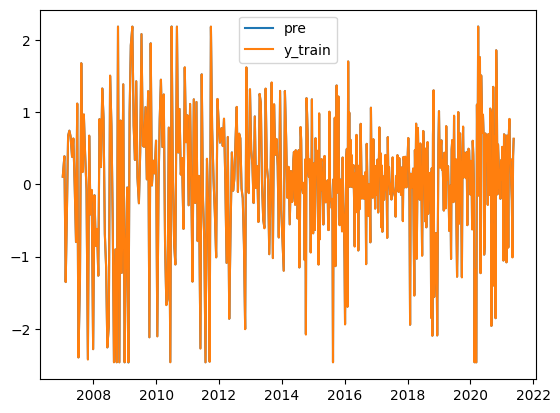

In [78]:
plt.plot(pre, label="pre")
plt.plot(y_train, label="y_train")
plt.legend()
plt.show()

In [79]:
cat_train = [1 if i>0 else -1 for i in y_train.values]
cat_pre = [1 if i>0 else -1 for i in pre.values]
print("Accuracy_score is {:.3f}".format(accuracy_score(cat_train, cat_pre)))
print("Recall score is {:.3f}".format(recall_score(cat_train, cat_pre)))
confusion_matrix(cat_train, cat_pre)

Accuracy_score is 0.998
Recall score is 0.997


array([[238,   0],
       [  1, 306]], dtype=int64)

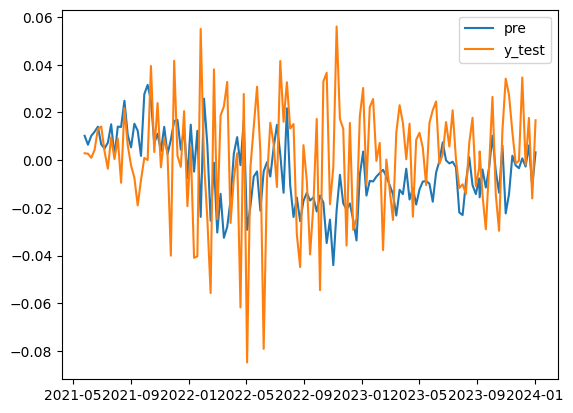

In [80]:
pre = regressor.predict(X_test)
pre = inverse_z_score(y_origin, pre)
pre = pd.Series(pre, y_test.index)

plt.plot(pre, label="pre")
plt.plot(y_test, label="y_test")
plt.legend()
plt.show()

In [81]:
cat_test = [1 if i>0 else -1 for i in y_test.values]
cat_pre = [1 if i>0 else -1 for i in pre.values]
print("Accuracy_score is {:.3f}".format(accuracy_score(cat_test, cat_pre)))
print("Recall score is {:.3f}".format(recall_score(cat_test, cat_pre))  )
confusion_matrix(cat_test, cat_pre)

Accuracy_score is 0.577
Recall score is 0.457


array([[42, 14],
       [44, 37]], dtype=int64)

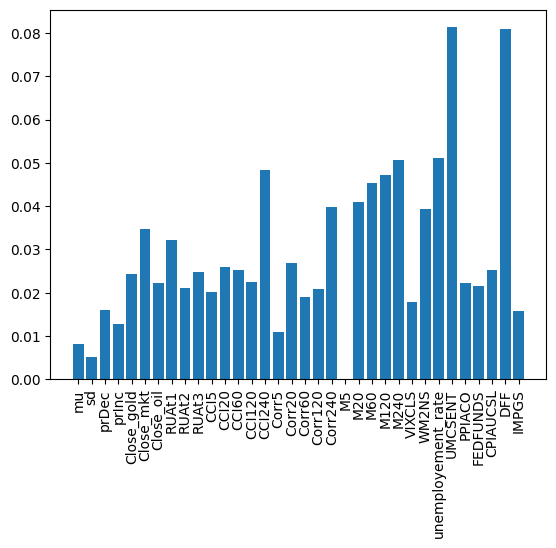

In [82]:
plt.bar(X_train.columns, regressor.feature_importances_)
plt.xticks(rotation=90)
plt.show()

# XGBoost Random Forest Regressor

In [15]:
regressor = XGBRFRegressor(objective="reg:squarederror",
                           n_estimator = 10000,
                           learning_rate = 1,
                           max_depth = 200,
                            random_state=42)
regressor.fit(X_train, y_train)
pre = regressor.predict(X_train)
pre = pd.Series(pre, y_train.index)

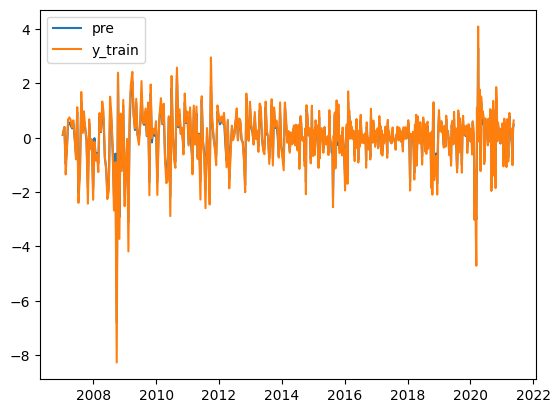

In [16]:
plt.plot(pre, label="pre")
plt.plot(y_train, label="y_train")
plt.legend()
plt.show()

In [17]:
cat_train = [1 if i>0 else -1 for i in y_train.values]
cat_pre = [1 if i>0 else -1 for i in pre.values]
print("Accuracy_score is {:.3f}".format(accuracy_score(cat_train, cat_pre)))
print("Recall score is {:.3f}".format(recall_score(cat_train, cat_pre)))
confusion_matrix(cat_train, cat_pre)

Accuracy_score is 0.952
Recall score is 0.941


array([[230,   8],
       [ 18, 289]], dtype=int64)

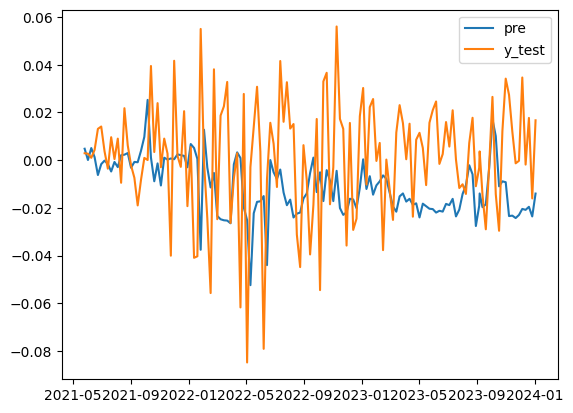

In [18]:
pre = regressor.predict(X_test)
pre = inverse_z_score(y_origin, pre)
pre = pd.Series(pre, y_test.index)

plt.plot(pre, label="pre")
plt.plot(y_test, label="y_test")
plt.legend()
plt.show()

In [19]:
cat_test = [1 if i>0 else -1 for i in y_test.values]
cat_pre = [1 if i>0 else -1 for i in pre.values]
print("Accuracy_score is {:.3f}".format(accuracy_score(cat_test, cat_pre)))
print("Recall score is {:.3f}".format(recall_score(cat_test, cat_pre)))
confusion_matrix(cat_test, cat_pre)

Accuracy_score is 0.474
Recall score is 0.235


array([[46, 10],
       [62, 19]], dtype=int64)